# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
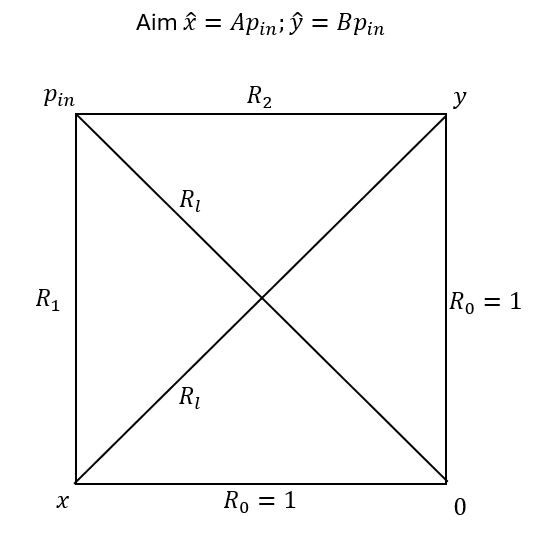
</div>


In [88]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        elif self.variabs.task_type == 'General_reg':
            self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + (syms.x-syms.y)**2 + \
                     (syms.y-syms.z)**2
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg':
            p_drawn = self.p_drawn_in_t[-1]
            p_drawn_prev = self.p_drawn_in_t[-2]
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
            p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
            print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
#             print('output', self.output)
#             print('output_prev', self.out_in_t[-2])
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        else:
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            self.R_in_t.append(R_ij)
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [103]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.2
        F = 0.3
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg':              
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()              
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x dual', 'y dual', 'p dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif task_type=='General_reg':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend2 = ['x dual', 'y dual', 'z dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:], '.')
        ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
    elif variabs.task_type=='Regression' or task_type=='General_reg':  # regression goes only every two samples
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
        ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    # ax4.plot(np.abs(state.loss_in_t[1:]))
    ax4.plot(np.mean(np.abs(state.loss_in_t[1:]),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [116]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([0.1])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
# task_type = 'Regression'
# task_type = 'Allostery'
task_type = 'General_reg'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=220

[[0.1 0.1 0.1]]
p_drawn [1.12478932 0.80013446]
desired [0.64994934 0.2324991  0.4649982 ]
output= [0.641641259572887 0.641641259572887 0.641641259572887]
p_drawn [1.92659751 1.67610416]
desired [1.18966504 0.44407537 0.88815075]
output= [1.20090055557724 1.20090055557724 1.20090055557724]
the dot for p -0.0503333366403921
loss= [[-0.0112355127801782 -0.756825180938862 -0.312749806300480]
 [0.00830808317052401 -0.409142158786336 -0.176643057999786]]
time= 1
p_nxt= [1.04035768139742 1.04409047784774]
dual output [0.498907006228722 0.480555503779831 0.492388103576391]
[1.04035768139742 1.04409047784774]
R_nxt [0.541450675168702, 0.559802177617592, 0.547969577821032, 0.545183471619023, 0.563534974067914, 0.551702374271353]
p_drawn [1.87397599 0.27766631]
desired [0.81900697 0.22904755 0.45809509]
output= [0.852197431042653 0.843592936144052 0.836263971760663]
p_drawn [1.79079211 1.12167501]
desired [0.9967356  0.34733046 0.69466093]
output= [1.14563330505487 1.14252685450211 1.13716317241

output= [0.721706775499272 0.698031293150750 0.703978048496864]
p_drawn [1.94302439 1.6182748 ]
desired [1.18177846 0.43704366 0.87408732]
output= [1.23014036326413 1.24275151002277 1.24406848417021]
the dot for p -0.0539984738268571
loss= [[-0.0483619069824734 -0.805707850994115 -0.369981166112888]
 [0.0289137673413608 -0.468354830322301 -0.244625122839965]]
time= 14
p_nxt= [1.37091341232892 1.31022046058007]
dual output [0.483354951471406 0.343287030952354 0.424023312579937]
[1.37091341232892 1.31022046058007]
R_nxt [0.887558460857515, 1.02762638137657, 0.946890099748984, 0.826865509108661, 0.966933429627713, 0.886197148000130]
p_drawn [0.5468382  0.11308576]
desired [0.24700672 0.07164668 0.14329337]
output= [0.231089123448650 0.221259072495514 0.219670980896818]
p_drawn [1.66154178 0.74867338]
desired [0.85178506 0.27845519 0.55691037]
output= [0.833796202424745 0.817817163826804 0.812228749858665]
the dot for p -0.0566619093799477
loss= [[0.0179888569718448 -0.539361977989360 -0.2

output= [0.902889580691015 0.931874180428669 0.928305177500105]
p_drawn [1.74044224 0.57074806]
desired [0.83886391 0.25965643 0.51931287]
output= [0.757243950628728 0.730456153447997 0.734380731264974]
the dot for p 0.0181532407099104
loss= [[0.0816199610539204 -0.470799719856610 -0.215067864082199]
 [0.00519842956824990 -0.575473880969825 -0.215504578582418]]
time= 27
p_nxt= [1.54055163475979 1.41203161828599]
dual output [0.490703111832055 0.277961508301555 0.395359976882599]
[1.54055163475979 1.41203161828599]
R_nxt [1.04984852292773, 1.26259012645823, 1.14519165787719, 0.921328506453934, 1.13407010998443, 1.01667164140339]
p_drawn [1.20050574 1.84510129]
desired [0.94147762 0.39681577 0.79363154]
output= [0.966140694598806 1.01288765598433 1.00541541849147]
p_drawn [0.97628375 0.63227869]
desired [0.54858317 0.19247018 0.38494036]
output= [0.520909568497343 0.519859995354603 0.518095727280832]
the dot for p 0.0419647259898830
loss= [[0.0276736046785344 -0.327389816739247 -0.133155

output= [0.947519035780968 0.970758109002364 0.956545230990359]
p_drawn [0.83026187 1.96166035]
desired [0.82251983 0.37727524 0.75455048]
output= [0.808555571798016 0.867924933453920 0.858037085384378]
the dot for p 0.00612050517705908
loss= [[0.0139642616819232 -0.490649694764080 -0.103486608004698]
 [0.0834056072320639 -0.569917895701293 -0.154864804388216]]
time= 39
p_nxt= [1.75009425449477 1.63188150822121]
dual output [0.500715247496431 0.169055217278088 0.360627639511764]
[1.75009425449477 1.63188150822121]
R_nxt [1.24937900699834, 1.58103903721668, 1.38946661498301, 1.13116626072478, 1.46282629094313, 1.27125386870945]
p_drawn [0.54927899 0.21225231]
desired [0.27277468 0.08676575 0.17353149]
output= [0.232787557180973 0.225244567683870 0.221224082592786]
p_drawn [0.29677568 0.76294612]
desired [0.3094468  0.14411949 0.28823897]
output= [0.305981800974337 0.330304306573937 0.326587579500515]
the dot for p -0.00748841337070032
loss= [[0.00346500087058016 -0.186184820778382 -0.03

output= [0.0282906071251362 0.0310352951429800 0.0308543373039800]
p_drawn [1.3325604  0.88281788]
desired [0.75372863 0.26567872 0.53135744]
output= [0.648216979321910 0.641006167842370 0.620060059822779]
the dot for p -0.0341325433398392
loss= [[0.105511650557419 -0.375327445838648 -0.0887026158153366]
 [0.000259618664443722 -0.0162229497815327 -0.00122964658108538]]
time= 52
p_nxt= [1.87084700545498 1.83066734512071]
dual output [0.514902469684189 0.0792973644160351 0.343208152876912]
[1.87084700545498 1.83066734512071]
R_nxt [1.35594453577079, 1.79154964103894, 1.52763885257807, 1.31576487543652, 1.75136998070467, 1.48745919224380]
p_drawn [1.77608097 1.31067898]
desired [1.03810213 0.37420994 0.74841989]
output= [0.887727800245015 0.884219903664939 0.857000260883724]
p_drawn [0.34480252 0.52730095]
desired [0.26974624 0.11357539 0.22715079]
output= [0.243298133098965 0.253213910606448 0.248079197755786]
the dot for p 0.0334097186507962
loss= [[0.0264481106694090 -0.139638516593173

output= [0.631405863014556 0.621284827757322 0.594929128748589]
p_drawn [0.65842427 0.83023023]
desired [0.47092727 0.19037696 0.38075392]
output= [0.403543206455487 0.414568230389937 0.402611880365702]
the dot for p 0.00910922219096579
loss= [[0.0673840590888795 -0.224191268824697 -0.0218579572352225]
 [0.138939836568763 -0.352112584071839 -0.0565846413776230]]
time= 64
p_nxt= [1.98378217046272 1.97247178326051]
dual output [0.536484889566002 -0.00258730262897006 0.332591770438983]
[1.98378217046272 1.97247178326051]
R_nxt [1.44729728089672, 1.98636947309169, 1.65119040002374, 1.43598689369451, 1.97505908588948, 1.63988001282153]
p_drawn [1.72709074e+00 3.22521444e-04]
desired [0.69091693 0.17275745 0.3455149 ]
output= [0.518749917538471 0.463597569601995 0.429459292974894]
p_drawn [1.29295467 1.23057568]
desired [0.82482579 0.31388182 0.62776364]
output= [0.692471803261559 0.699145964204425 0.675261699906430]
the dot for p -0.00977907291226408
loss= [[0.132353983136010 -0.38526414584

output= [0.510205851247976 0.473976781818991 0.441671919486490]
p_drawn [0.08170033 0.66696013]
desired [0.19942016 0.10821405 0.2164281 ]
output= [0.183614736499371 0.207378081350966 0.206729785193152]
the dot for p 0.0103480921757547
loss= [[0.0158054280778339 -0.0991640291630982 0.00969831918258313]
 [0.155828191069247 -0.279750346293655 -0.0532190484358193]]
time= 76
p_nxt= [2.07240758173763 2.06316418801160]
dual output [0.561824447478979 -0.0689388495679259 0.326988466564712]
[2.07240758173763 2.06316418801160]
R_nxt [1.51058313425865, 2.14134643130556, 1.74541911517292, 1.50133974053263, 2.13210303757953, 1.73617572144689]
p_drawn [1.18017649 0.87725817]
desired [0.69138514 0.24960637 0.49921275]
output= [0.557617315234358 0.553831976316442 0.529603064511024]
p_drawn [0.65186403 0.74916114]
desired [0.4480359  0.17756057 0.35512115]
output= [0.371145111535522 0.379923484144947 0.366884130230219]
the dot for p 0.00636129893753450
loss= [[0.0768907863252991 -0.202362909552268 -0.0

output= [0.349779261359001 0.405040976615663 0.404390438923389]
p_drawn [0.56848888 1.13029571]
desired [0.50996948 0.22639324 0.45278649]
output= [0.425710113152624 0.453871721383518 0.441783573315740]
the dot for p -0.00164271290099372
loss= [[0.0842593645806404 -0.227478477633559 0.0110029141841800]
 [0.0396221839334582 -0.187034256033399 0.0316230022411395]]
time= 89
p_nxt= [2.15640316585290 2.16201415277926]
dual output [0.595132061081827 -0.146554883032615 0.325410136072637]
[2.15640316585290 2.16201415277926]
R_nxt [1.56127110477107, 2.30295804888552, 1.83099302978026, 1.56688209169744, 2.30856903581188, 1.83660401670663]
p_drawn [1.3160646  0.45046225]
desired [0.6390414 0.1991758 0.3983516]
output= [0.487110711303542 0.459186992267082 0.428033300443620]
p_drawn [0.51847431 1.41483886]
desired [0.56109944 0.26407326 0.52814652]
output= [0.476561590961095 0.518855277938304 0.508386523094752]
the dot for p -0.00127219641299851
loss= [[0.0845378487139484 -0.254782017725314 0.01975

output= [0.576104171984749 0.530342401869530 0.489265849436238]
p_drawn [1.7423685  1.02732036]
desired [0.95377749 0.3283349  0.65666981]
output= [0.732407859436664 0.713496069361259 0.671287872813108]
the dot for p -0.00457136612040955
loss= [[0.221369628769654 -0.385161165829769 -0.0146180657501277]
 [0.198589959448260 -0.300901618452409 -0.0303842826019967]]
time= 102
p_nxt= [2.23426481472610 2.21889248745041]
dual output [0.633256308969933 -0.214515957679307 0.323881865920761]
[2.23426481472610 2.21889248745041]
R_nxt [1.60100850575617, 2.44878077240541, 1.91038294880534, 1.58563617848047, 2.43340844512971, 1.89501062152965]
p_drawn [1.17094778 1.6749887 ]
desired [0.88712629 0.36834308 0.73668617]
output= [0.712757702130977 0.746384104955312 0.718519177805993]
p_drawn [0.02867229 1.41258233]
desired [0.3646145  0.21475458 0.42950916]
output= [0.324763787635398 0.390239553530224 0.390466729966205]
the dot for p 0.00889136138807972
loss= [[0.0398507113524211 -0.175484975083044 0.03

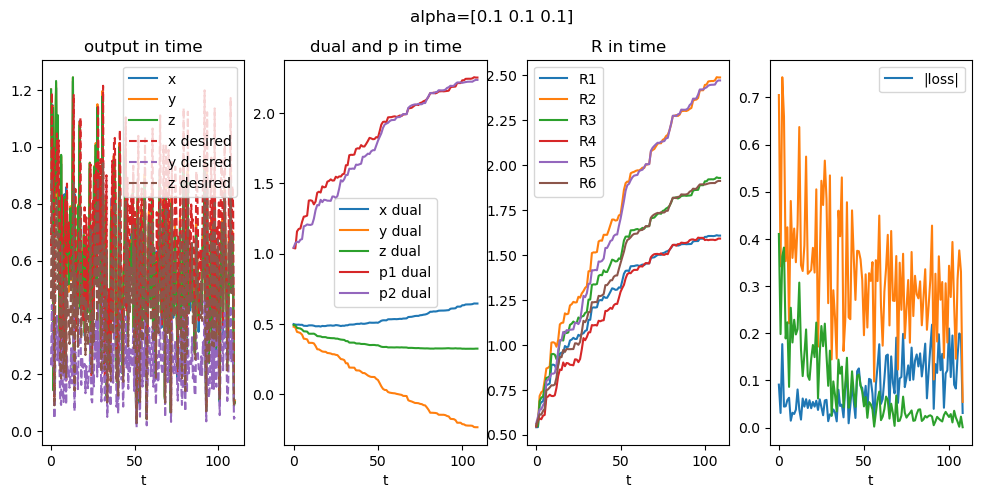

In [117]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0)

In [102]:
np.mean(np.abs(state.loss_in_t[1:]),axis=1).size

29

In [ ]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")